In [1]:
import sys,os,argparse,time
import numpy as np
import torch
import utils
from datetime import datetime
import pickle
import pandas as pd
tstart=time.time()
import matplotlib.pyplot as plt 
from tabulate import tabulate

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Arguments
parser=argparse.ArgumentParser(description='xxx')
parser.add_argument('--seed',               default=0,                    type=int,     help='(default=%(default)d)')
parser.add_argument('--device',             default='cpu',                type=str,     help='gpu id')
parser.add_argument('--experiment',         default='16_task_groups',     type =str,    help='Mnist or dissertation')
parser.add_argument('--approach',           default='PUGCL',              type =str,    help='Method, always Lifelong Uncertainty-aware learning')
parser.add_argument('--data_path',          default='data/data_test.csv', type=str,     help='gpu id')

# Training parameters
parser.add_argument('--output',             default='',                           type=str,     help='')
parser.add_argument('--checkpoint_dir',     default='../checkpoints_16_tasks',    type=str,     help='')
parser.add_argument('--n_epochs',           default=100,                          type=int,     help='')
parser.add_argument('--batch_size',         default=64,                           type=int,     help='')
parser.add_argument('--lr',                 default=0.03,                         type=float,   help='')
parser.add_argument('--hidden_size',        default=800,                          type=int,     help='')
parser.add_argument('--parameter',          default='',                           type=str,     help='')

# UCB HYPER-PARAMETERS
parser.add_argument('--MC_samples',         default='10',           type=int,     help='Number of Monte Carlo samples')
parser.add_argument('--rho',                default='-3',           type=float,   help='Initial rho')
parser.add_argument('--sigma1',             default='0.0',          type=float,   help='STD foor the 1st prior pdf in scaled mixture Gaussian')
parser.add_argument('--sigma2',             default='6.0',          type=float,   help='STD foor the 2nd prior pdf in scaled mixture Gaussian')
parser.add_argument('--pi',                 default='0.25',         type=float,   help='weighting factor for prior')

parser.add_argument('--resume',             default='no',           type=str,     help='resume?')
parser.add_argument('--sti',                default=1,              type=int,     help='starting task?')

parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

args=parser.parse_args()
utils.print_arguments(args)

Arguments =
	seed: 0
	device: cpu
	experiment: 16_task_groups
	approach: PUGCL
	data_path: data/data_test.csv
	output: 
	checkpoint_dir: ../checkpoints_16_tasks
	n_epochs: 100
	batch_size: 64
	lr: 0.03
	hidden_size: 800
	parameter: 
	MC_samples: 10
	rho: -3.0
	sigma1: 0.0
	sigma2: 6.0
	pi: 0.25
	resume: no
	sti: 1
	fff: /Users/jonastjomsland/Library/Jupyter/runtime/kernel-791fa477-60c8-4c4c-9c34-d454e096d86d.json


In [4]:
# Set seed for stable results
np.random.seed(args.seed)
torch.manual_seed(args.seed)

# Check if Cuda is available
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Using device:", args.device)

# PUGCL with two tasks:
from data import dataloader_16_tasks as dataloader

# Import Lifelong Uncertainty-aware Learning approach:
from training_method import PUGCL

#from bayesian_model.bayesian_network import BayesianNetwork
from bayesian_model.bayesian_network import BayesianNetwork

# Load training data:
print("Loading data...")
data, task_outputs, input_size = dataloader.get(data_path='data/data.csv')
print("Input size =", input_size, "\nTask info =", task_outputs)
print("Number of data samples: ", len(data[0]['train']['x']))
args.num_tasks = len(task_outputs)
args.input_size = input_size
args.task_outputs = task_outputs
# Checkpoint
checkpoint = utils.make_directories(args)
args.checkpoint = checkpoint
print()

# Initialize Bayesian network
print("Initializing network...")
model = BayesianNetwork(args).to(args.device)

# Initialize Lul approach
print("Initialize Lifelong Uncertainty-aware Learning")
approach = PUGCL(model, args=args)
print("-"*100)

# Load stored model:
model_number = 15
checkpoint = torch.load(os.path.join(args.checkpoint, 'model_{}.pth.tar'.format(model_number)), map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device=args.device).eval()

Using device: cpu
Loading data...
Input size = [1, 29] 
Task info = [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2)]
Number of data samples:  500
16_task_groups_PUGCL
Results will be saved in  ../checkpoints_16_tasks/16_task_groups_PUGCL

Initializing network...
Initialize Lifelong Uncertainty-aware Learning
----------------------------------------------------------------------------------------------------


In [5]:
# Load features:
df_x1 = pd.read_csv('/Users/jonastjomsland/Dissertation/scripts_and_data/features4.csv')
df_x1 = df_x1.iloc[:, :-1]
df_x2 = pd.read_csv('/Users/jonastjomsland/Dissertation/data/features5.csv', sep=';')
df_x2.columns = df_x2.iloc[0]
df_x2 = df_x2.drop(df_x2.index[0])
df_x2 = df_x2.iloc[:, :-1]

features = pd.concat([df_x1, df_x2])
features = features.iloc[:-40,:-12]
features['Stamp'] = features['Stamp'].astype(int)

In [6]:
# Load test data:
full_set = pd.read_csv(args.data_path)
full_set['Stamp'] = full_set['Stamp'].astype(int)
# Split in circle and arrow
df_circle = full_set[full_set['Using circle'] == 1]
df_arrow = full_set[full_set['Using circle'] == 0]
actions = [['Vacuum cleaning', 'Mopping the floor', 'Carry warm food', 'Carry cold food', 'Carry drinks', 'Carry small objects (plates, toys)', 'Carry big objects (tables, chairs)', 'Cleaning (Picking up stuff)'], ['Vacuum cleaning', 'Mopping the floor', 'Carry warm food', 'Carry cold food', 'Carry drinks', 'Carry small objects (plates, toys)', 'Carry big objects (tables, chairs)', 'Starting conversation']]

In [7]:
# Do 100 MC samples of inference 
x_circle = torch.tensor(df_circle.iloc[:,0:30].drop_duplicates().values).type(torch.float32)
x_arrow = torch.tensor(df_arrow.iloc[:,0:30].drop_duplicates().values).type(torch.float32)
test_scenes = [[df_circle.iloc[:,0:30].drop_duplicates().Stamp.values][0], [df_arrow.iloc[:,0:30].drop_duplicates().Stamp.values][0]]
# Dict with numpy arrays of outputs:
model_output = {}
first_it = True
for sample in range(100):
    output_circle = model(x_circle[:,1:], sample = False, sample_last_layer = False)
    output_arrow = model(x_arrow[:,1:], sample = False, sample_last_layer = False)
    # Append output
    # Circle actions
    for i, action in enumerate(actions[0]):
        if first_it:
            model_output[i] = output_circle[i].detach().numpy()
        else:
            model_output[i] = np.dstack([model_output[i],output_circle[i].detach().numpy()])
    # Arrow actions
    for i, action in enumerate(actions[1]):
        if first_it:
            model_output[i+8] = output_arrow[i+8].detach().numpy()
        else:
            model_output[i+8] = np.dstack([model_output[i+8],output_arrow[i+8].detach().numpy()])
    first_it = False

In [8]:
evaluation_dict = {}
for action_type in test_scenes:
    for scene_index, scene in enumerate(action_type):
        evaluation_dict[scene] = {}
        # Scene stamp for image
        evaluation_dict[scene]['Stamp'] = scene
        
        # Features of the scene
        evaluation_dict[scene]['Features'] = features[features.Stamp == scene].values[0][2:].astype(float)
        # Actions for that scene
        evaluation_dict[scene]['Actions'] = actions[int(evaluation_dict[scene]['Features'][1])]
        
        # Using circle or arrow
        if evaluation_dict[scene]['Features'][0] == 1:
            # Scene is with circle
            evaluation_dict[scene]['Using circle'] = True
            scene_df = df_circle[df_circle.Stamp == scene]
        else:
            evaluation_dict[scene]['Using circle'] = False
            scene_df = df_arrow[df_arrow.Stamp == scene]
        
        # Labeled answers
        evaluation_dict[scene]['Mean label'] = scene_df.mean(axis = 0).values[30:]
        evaluation_dict[scene]['Variance in labels'] = scene_df.var(axis = 0).values[30:]
        
        # Predicted values:
        evaluation_dict[scene]['Predicted mean'] = []
        evaluation_dict[scene]['Aleatoric uncertainty'] = []
        evaluation_dict[scene]['Epistemic uncertainty'] = []
        # Iterate over actions:
        for i in range(8):
            if evaluation_dict[scene]['Features'][0] == 0:
                i += 8
            mean = model_output[i][scene_index, 0, :]
            variance = np.exp(model_output[i][scene_index ,1,:])
            # Append predictive mean
            evaluation_dict[scene]['Predicted mean'].append(np.mean(mean))
            # Append Aleatoric
            evaluation_dict[scene]['Aleatoric uncertainty'].append(np.mean(variance))
            # Append Epistemic
            evaluation_dict[scene]['Epistemic uncertainty'].append(np.mean(np.square(mean)) - np.square(np.mean(mean)))
            
        # Put everything into a table for that scene:
        evaluation_dict[scene]['Table'] = [evaluation_dict[scene]['Actions'], evaluation_dict[scene]['Mean label'], evaluation_dict[scene]['Variance in labels'], evaluation_dict[scene]['Predicted mean'], evaluation_dict[scene]['Aleatoric uncertainty'], evaluation_dict[scene]['Epistemic uncertainty']]
        

In [9]:
scene_df = df_arrow[df_arrow.Stamp == 720]
print(scene_df.var(axis = 0).values[30:])
print(evaluation_dict[720]['Predicted mean'])
display(scene_df)

[1.2967033  1.05494505 1.82417582 1.69230769 1.82417582 1.93956044
 2.37912088 1.91758242]
[2.9195523, 1.2973708, 2.2251823, 3.3776963, 2.7294974, 3.7931528, 3.0560086, 3.596843]


Stamp  Using circle  Using arrow  Number of people  \
105    720           0.0          1.0               0.0   
106    720           0.0          1.0               0.0   
107    720           0.0          1.0               0.0   
108    720           0.0          1.0               0.0   
109    720           0.0          1.0               0.0   
110    720           0.0          1.0               0.0   
111    720           0.0          1.0               0.0   
112    720           0.0          1.0               0.0   
113    720           0.0          1.0               0.0   
114    720           0.0          1.0               0.0   
115    720           0.0          1.0               0.0   
116    720           0.0          1.0               0.0   
117    720           0.0          1.0               0.0   
118    720           0.0          1.0               0.0   

     Number of people in group  Group radius  Distance to group  \
105                        0.0           1.0                1.0   
106                        0.0           1.0                1.0   
107                        0.0           1.0                1.0   
108                        0.0           1.0                1.0   
109                        0.0           1.0                1.0   
110                        0.0           1.0                1.0   
111                        0.0           1.0                1.0   
112                        0.0           1.0                1.0   
113                        0.0           1.0                1.0   
114                        0.0           1.0                1.0   
115                        0.0           1.0                1.0   
116                        0.0           1.0                1.0   
117                        0.0           1.0                1.0   
118                        0.0           1.0                1.0   

     Robot within group?  Robot facing group?  Robot work radius  ...  \
105                  0.0                  0.0                0.0  ...   
106                  0.0                  0.0                0.0  ...   
107                  0.0                  0.0                0.0  ...   
108                  0.0                  0.0                0.0  ...   
109                  0.0                  0.0                0.0  ...   
110                  0.0                  0.0                0.0  ...   
111                  0.0                  0.0                0.0  ...   
112                  0.0                  0.0                0.0  ...   
113                  0.0                  0.0                0.0  ...   
114                  0.0                  0.0                0.0  ...   
115                  0.0                  0.0                0.0  ...   
116                  0.0                  0.0                0.0  ...   
117                  0.0                  0.0                0.0  ...   
118                  0.0                  0.0                0.0  ...   

     Music playing?  Number of agents in scene  Vacuum cleaning  \
105             0.0                        0.0              4.0   
106             0.0                        0.0              2.0   
107             0.0                        0.0              4.0   
108             0.0                        0.0              5.0   
109             0.0                        0.0              4.0   
110             0.0                        0.0              2.0   
111             0.0                        0.0              2.0   
112             0.0                        0.0              3.0   
113             0.0                        0.0              5.0   
114             0.0                        0.0              4.0   
115             0.0                        0.0              3.0   
116             0.0                        0.0              4.0   
117             0.0                        0.0              5.0   
118             0.0                        0.0              5.0   

     Moppin

Scene number: 870


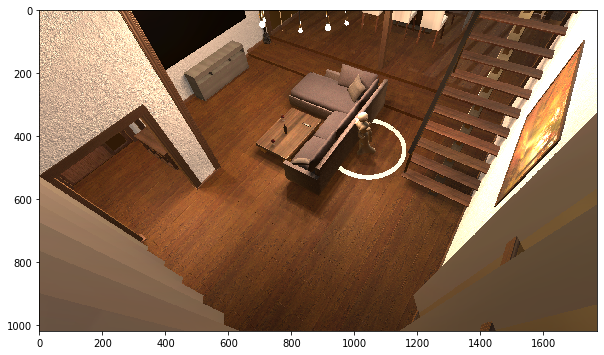

Mean label  Variance in labels  \
Actions                                                              
Vacuum cleaning                       4.846154            0.307692   
Mopping the floor                     4.846154            0.307692   
Carry warm food                       4.230769            1.525641   
Carry cold food                       4.230769            1.525641   
Carry drinks                          4.230769            1.525641   
Carry small objects (plates, toys)    4.538462            0.935897   
Carry big objects (tables, chairs)    4.615385            0.589744   
Cleaning (Picking up stuff)           4.769231            0.358974   

                                    Predicted mean  Aleatoric uncertainty  \
Actions                                                                     
Vacuum cleaning                           2.293089               6.271391   
Mopping the floor                         1.844710               1.261918   
Carry warm food                           1.759161               2.145817   
Carry cold food                           2.806715               3.669057   
Carry drinks                              3.086530               2.876660   
Carry small objects (plates, toys)        3.914400               3.209337   
Carry big objects (tables, chairs)        1.836282               4.925880   
Cleaning (Picking up stuff)               3.366236               0.870728   

                                    Epistemic uncertainty  
Actions                                                    
Vacuum cleaning                                  1.656732  
Mopping the floor                                2.011480  
Carry warm food                                  1.799437  
Carry cold food                                  1.555014  
Carry drinks                                     1.399634  
Carry small objects (plates, toys)               1.974925  
Carry big objects (tables, chairs)               1.824298  
Cleaning (Picking up stuff)                      1.801152

Scene number: 769


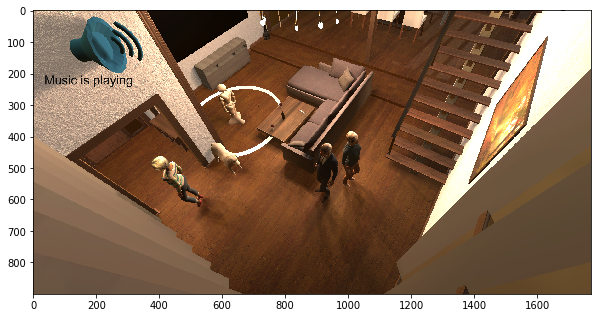

Mean label  Variance in labels  \
Actions                                                              
Vacuum cleaning                       2.533333            2.123810   
Mopping the floor                     2.933333            1.923810   
Carry warm food                       2.733333            1.638095   
Carry cold food                       2.733333            1.638095   
Carry drinks                          2.800000            1.742857   
Carry small objects (plates, toys)    3.000000            1.571429   
Carry big objects (tables, chairs)    2.533333            1.695238   
Cleaning (Picking up stuff)           3.133333            1.695238   

                                    Predicted mean  Aleatoric uncertainty  \
Actions                                                                     
Vacuum cleaning                           1.739099               4.924123   
Mopping the floor                         2.774429               0.893824   
Carry warm food                           1.925983               1.400338   
Carry cold food                           2.428589               2.592012   
Carry drinks                              2.132121               1.877553   
Carry small objects (plates, toys)        3.125837               4.455837   
Carry big objects (tables, chairs)        1.321156               4.835321   
Cleaning (Picking up stuff)               2.562713               1.150861   

                                    Epistemic uncertainty  
Actions                                                    
Vacuum cleaning                                  1.142072  
Mopping the floor                                0.939610  
Carry warm food                                  1.224472  
Carry cold food                                  1.284307  
Carry drinks                                     1.196268  
Carry small objects (plates, toys)               1.179161  
Carry big objects (tables, chairs)               1.235256  
Cleaning (Picking up stuff)                      1.106468

Scene number: 432


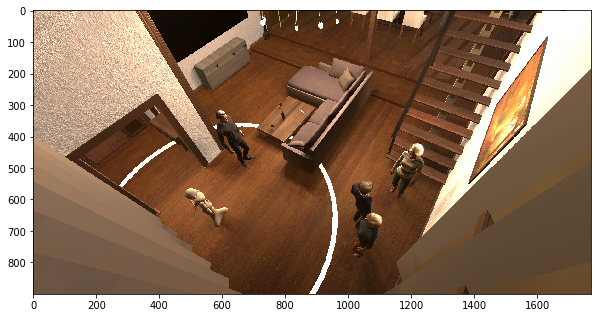

Mean label  Variance in labels  \
Actions                                                              
Vacuum cleaning                       2.142857            1.824176   
Mopping the floor                     2.142857            1.824176   
Carry warm food                       3.785714            0.335165   
Carry cold food                       3.928571            0.532967   
Carry drinks                          3.928571            0.532967   
Carry small objects (plates, toys)    3.714286            0.373626   
Carry big objects (tables, chairs)    2.285714            0.989011   
Cleaning (Picking up stuff)           3.428571            0.879121   

                                    Predicted mean  Aleatoric uncertainty  \
Actions                                                                     
Vacuum cleaning                           2.137195               4.186119   
Mopping the floor                         2.723893               1.194234   
Carry warm food                           3.355911               2.969711   
Carry cold food                           1.802324               2.128167   
Carry drinks                              2.821047               2.384276   
Carry small objects (plates, toys)        3.283945               2.040395   
Carry big objects (tables, chairs)        2.499099               6.151648   
Cleaning (Picking up stuff)               2.805941               1.243304   

                                    Epistemic uncertainty  
Actions                                                    
Vacuum cleaning                                  1.149857  
Mopping the floor                                1.074524  
Carry warm food                                  1.083640  
Carry cold food                                  0.875925  
Carry drinks                                     0.976476  
Carry small objects (plates, toys)               1.011641  
Carry big objects (tables, chairs)               1.208354  
Cleaning (Picking up stuff)                      1.148436

Scene number: 311


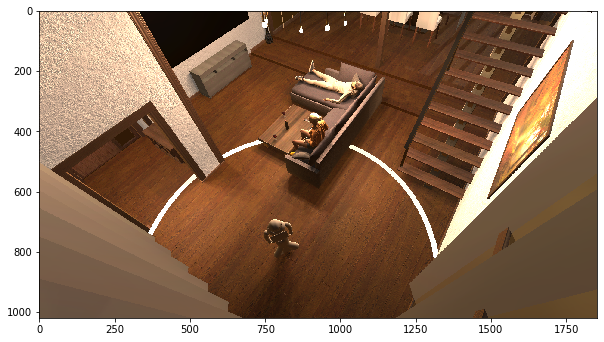

Mean label  Variance in labels  \
Actions                                                              
Vacuum cleaning                       2.666667            2.380952   
Mopping the floor                     3.333333            1.523810   
Carry warm food                       3.600000            1.114286   
Carry cold food                       3.666667            1.095238   
Carry drinks                          3.733333            1.209524   
Carry small objects (plates, toys)    3.933333            0.495238   
Carry big objects (tables, chairs)    3.066667            1.780952   
Cleaning (Picking up stuff)           2.866667            1.695238   

                                    Predicted mean  Aleatoric uncertainty  \
Actions                                                                     
Vacuum cleaning                           2.256581               3.022183   
Mopping the floor                         1.832748               0.654122   
Carry warm food                           1.913153               5.256808   
Carry cold food                           1.960318               5.387123   
Carry drinks                              3.146228               1.252817   
Carry small objects (plates, toys)        2.999574               0.813500   
Carry big objects (tables, chairs)        1.639550               4.034122   
Cleaning (Picking up stuff)               3.125946               2.051724   

                                    Epistemic uncertainty  
Actions                                                    
Vacuum cleaning                                  1.220454  
Mopping the floor                                1.218441  
Carry warm food                                  1.268792  
Carry cold food                                  1.199251  
Carry drinks                                     1.213514  
Carry small objects (plates, toys)               1.409514  
Carry big objects (tables, chairs)               1.485373  
Cleaning (Picking up stuff)                      1.374382

Scene number: 938


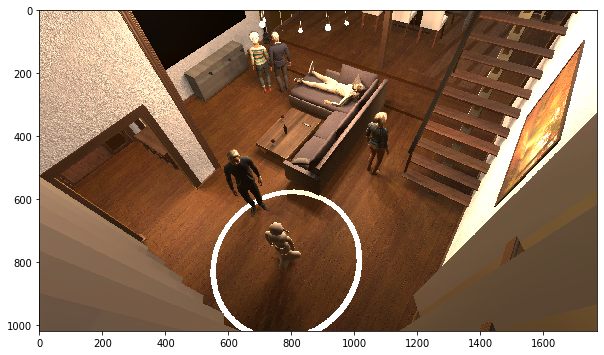

Mean label  Variance in labels  \
Actions                                                              
Vacuum cleaning                         2.3750            1.316667   
Mopping the floor                       2.3750            1.450000   
Carry warm food                         3.5625            0.662500   
Carry cold food                         3.7500            0.733333   
Carry drinks                            3.8125            0.562500   
Carry small objects (plates, toys)      3.5625            0.929167   
Carry big objects (tables, chairs)      2.2500            1.533333   
Cleaning (Picking up stuff)             3.1250            1.183333   

                                    Predicted mean  Aleatoric uncertainty  \
Actions                                                                     
Vacuum cleaning                           2.241204               3.264999   
Mopping the floor                         2.943391               1.161615   
Carry warm food                           2.360723               1.007303   
Carry cold food                           3.079330               3.101466   
Carry drinks                              2.301991               2.190146   
Carry small objects (plates, toys)        3.263319               1.760298   
Carry big objects (tables, chairs)        2.995671               2.735205   
Cleaning (Picking up stuff)               2.960113               1.187097   

                                    Epistemic uncertainty  
Actions                                                    
Vacuum cleaning                                  1.270734  
Mopping the floor                                1.353008  
Carry warm food                                  1.236612  
Carry cold food                                  1.288118  
Carry drinks                                     1.288635  
Carry small objects (plates, toys)               1.253196  
Carry big objects (tables, chairs)               1.472676  
Cleaning (Picking up stuff)                      1.225478

Scene number: 974


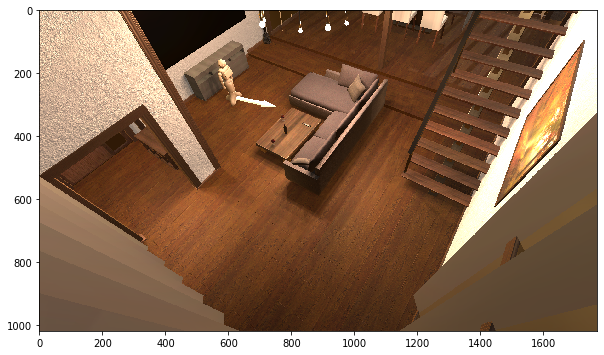

Mean label  Variance in labels  \
Actions                                                              
Vacuum cleaning                       4.533333            0.695238   
Mopping the floor                     4.533333            0.695238   
Carry warm food                       3.800000            2.028571   
Carry cold food                       3.800000            2.028571   
Carry drinks                          3.800000            2.028571   
Carry small objects (plates, toys)    4.400000            0.685714   
Carry big objects (tables, chairs)    4.266667            1.066667   
Starting conversation                 2.400000            2.828571   

                                    Predicted mean  Aleatoric uncertainty  \
Actions                                                                     
Vacuum cleaning                           2.919552               3.569792   
Mopping the floor                         1.297371               2.970750   
Carry warm food                           2.225182               1.357675   
Carry cold food                           3.377696               2.873866   
Carry drinks                              2.729497               3.715527   
Carry small objects (plates, toys)        3.793153               3.749317   
Carry big objects (tables, chairs)        3.056009               2.547361   
Starting conversation                     3.596843               3.270937   

                                    Epistemic uncertainty  
Actions                                                    
Vacuum cleaning                                  1.565969  
Mopping the floor                                1.876652  
Carry warm food                                  1.367620  
Carry cold food                                  1.552813  
Carry drinks                                     1.217657  
Carry small objects (plates, toys)               1.392376  
Carry big objects (tables, chairs)               1.382226  
Starting conversation                            1.482316

Scene number: 795


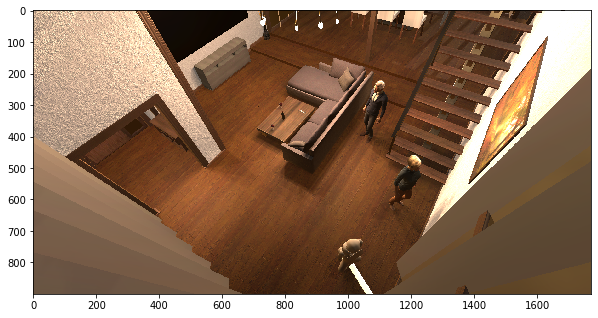

Mean label  Variance in labels  \
Actions                                                              
Vacuum cleaning                       3.071429            3.302198   
Mopping the floor                     3.000000            2.923077   
Carry warm food                       3.571429            2.417582   
Carry cold food                       3.785714            1.719780   
Carry drinks                          3.714286            1.912088   
Carry small objects (plates, toys)    3.642857            1.785714   
Carry big objects (tables, chairs)    3.142857            3.054945   
Starting conversation                 2.785714            1.873626   

                                    Predicted mean  Aleatoric uncertainty  \
Actions                                                                     
Vacuum cleaning                           2.750885               3.910016   
Mopping the floor                         1.322039               3.288805   
Carry warm food                           2.301259               0.929336   
Carry cold food                           3.085824               2.222859   
Carry drinks                              2.230710               2.218516   
Carry small objects (plates, toys)        3.648264               2.109667   
Carry big objects (tables, chairs)        2.422596               4.020870   
Starting conversation                     2.609386               3.504907   

                                    Epistemic uncertainty  
Actions                                                    
Vacuum cleaning                                  1.009262  
Mopping the floor                                0.949297  
Carry warm food                                  1.268146  
Carry cold food                                  1.223756  
Carry drinks                                     0.933477  
Carry small objects (plates, toys)               0.975313  
Carry big objects (tables, chairs)               1.047855  
Starting conversation                            0.933778

Scene number: 277


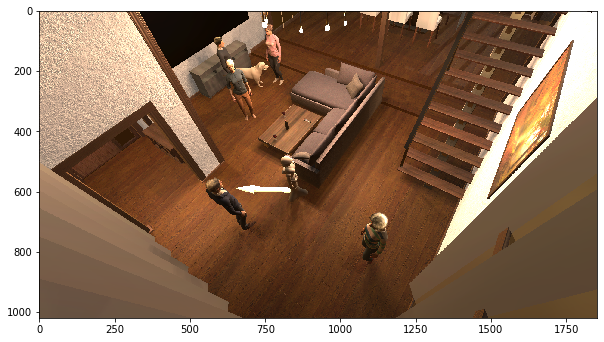

Mean label  Variance in labels  \
Actions                                                              
Vacuum cleaning                       3.263158            1.426901   
Mopping the floor                     3.000000            1.333333   
Carry warm food                       3.263158            1.760234   
Carry cold food                       3.368421            1.578947   
Carry drinks                          3.315789            1.783626   
Carry small objects (plates, toys)    3.526316            1.485380   
Carry big objects (tables, chairs)    2.947368            2.052632   
Starting conversation                 3.894737            1.432749   

                                    Predicted mean  Aleatoric uncertainty  \
Actions                                                                     
Vacuum cleaning                           2.612866               3.030068   
Mopping the floor                         1.906907               3.587041   
Carry warm food                           2.165211               1.117759   
Carry cold food                           2.604089               3.396286   
Carry drinks                              3.147247               2.408342   
Carry small objects (plates, toys)        3.662858               2.162181   
Carry big objects (tables, chairs)        2.034494               5.309714   
Starting conversation                     2.889721               1.561394   

                                    Epistemic uncertainty  
Actions                                                    
Vacuum cleaning                                  1.051975  
Mopping the floor                                1.316999  
Carry warm food                                  1.537395  
Carry cold food                                  1.201323  
Carry drinks                                     1.061294  
Carry small objects (plates, toys)               1.162724  
Carry big objects (tables, chairs)               1.168499  
Starting conversation                            1.206302

Scene number: 978


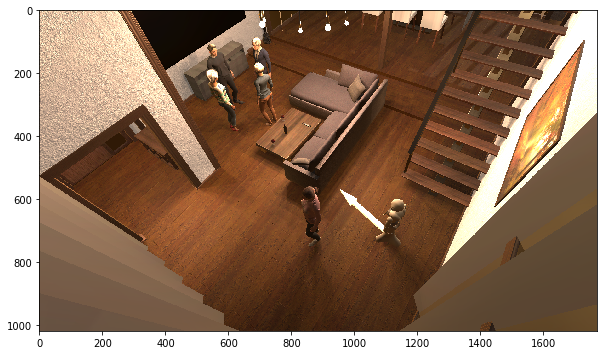

Mean label  Variance in labels  \
Actions                                                              
Vacuum cleaning                       2.266667            1.780952   
Mopping the floor                     2.333333            1.809524   
Carry warm food                       3.866667            0.838095   
Carry cold food                       3.933333            0.923810   
Carry drinks                          3.933333            0.923810   
Carry small objects (plates, toys)    3.866667            0.980952   
Carry big objects (tables, chairs)    2.333333            0.952381   
Starting conversation                 3.333333            1.380952   

                                    Predicted mean  Aleatoric uncertainty  \
Actions                                                                     
Vacuum cleaning                           1.346946               4.581027   
Mopping the floor                         0.811197               2.152910   
Carry warm food                           2.830306               1.661147   
Carry cold food                           2.506891               3.721483   
Carry drinks                              1.787012               3.306776   
Carry small objects (plates, toys)        3.160365               1.637156   
Carry big objects (tables, chairs)        2.899805               1.641828   
Starting conversation                     2.647523               1.987021   

                                    Epistemic uncertainty  
Actions                                                    
Vacuum cleaning                                  0.971083  
Mopping the floor                                0.964962  
Carry warm food                                  1.176665  
Carry cold food                                  0.951826  
Carry drinks                                     1.070495  
Carry small objects (plates, toys)               0.946555  
Carry big objects (tables, chairs)               0.857172  
Starting conversation                            0.985176

Scene number: 720


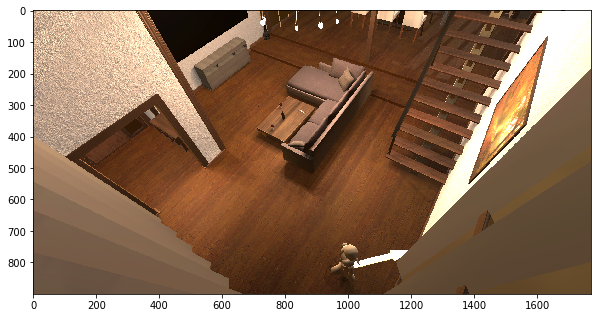

Mean label  Variance in labels  \
Actions                                                              
Vacuum cleaning                       3.714286            1.296703   
Mopping the floor                     3.857143            1.054945   
Carry warm food                       2.857143            1.824176   
Carry cold food                       3.000000            1.692308   
Carry drinks                          2.857143            1.824176   
Carry small objects (plates, toys)    3.357143            1.939560   
Carry big objects (tables, chairs)    2.928571            2.379121   
Starting conversation                 2.928571            1.917582   

                                    Predicted mean  Aleatoric uncertainty  \
Actions                                                                     
Vacuum cleaning                           2.919552               3.569792   
Mopping the floor                         1.297371               2.970750   
Carry warm food                           2.225182               1.357675   
Carry cold food                           3.377696               2.873866   
Carry drinks                              2.729497               3.715527   
Carry small objects (plates, toys)        3.793153               3.749317   
Carry big objects (tables, chairs)        3.056009               2.547361   
Starting conversation                     3.596843               3.270937   

                                    Epistemic uncertainty  
Actions                                                    
Vacuum cleaning                                  1.565969  
Mopping the floor                                1.876652  
Carry warm food                                  1.367620  
Carry cold food                                  1.552813  
Carry drinks                                     1.217657  
Carry small objects (plates, toys)               1.392376  
Carry big objects (tables, chairs)               1.382226  
Starting conversation                            1.482316

In [10]:
# Print evaluation along with image
counter = 0
for action_type in test_scenes:
    for scene_index, scene in enumerate(action_type):
        print('Scene number:', scene)
        # Print image
        if features.loc[features['Stamp'] == scene].empty:
            image_path = '/Users/jonastjomsland/Dissertation/' + features.loc[features['Stamp'] == str(scene)]['File Path'].values[0]
        else:
            image_path = '/Users/jonastjomsland/Dissertation/' + features.loc[features['Stamp'] == scene]['File Path'].values[0]
        img = plt.imread(image_path)
        plt.figure(figsize = (10,12))
        plt.rcParams["axes.grid"] = False
        imgplot = plt.imshow(img)
        plt.show()
        # Create dataframe to view results:
        eval_df = pd.DataFrame(columns= ['Mean label', 'Variance in labels', 'Predicted mean', 'Aleatoric uncertainty', 'Epistemic uncertainty'])
        for column in eval_df:
            eval_df[column] = evaluation_dict[scene][column]
        eval_df.index = evaluation_dict[scene]['Actions']
        eval_df.index.name = 'Actions'
        display(eval_df)
        counter += 1
        if counter > 4:
            counter = 0
            break